## Data Preprocessing

In [1]:
# Install required package
!pip install timm --quiet

In [15]:
# Import packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import timm
import time
import matplotlib.pyplot as plt
import tqdm
import copy

In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Using device: cuda
GPU name: NVIDIA GeForce RTX 3070 Laptop GPU


## Load and preprocess CIFAR-10

In [17]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Define training and evaluation utilities

In [18]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def evaluate(model, test_loader, device, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss

## DeiT Tiny2 Training loop

In [19]:
# Load DeiT Tiny and modify head for 10-class classification
model = timm.create_model('deit_tiny_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)
model = model.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_acc = 0
patience = 2
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(5):
    start = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = evaluate(model, test_loader, device, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/5] - Time: {time.time() - start:.2f}s")
    print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(best_model_wts, 'best_deit_tiny.pth')
        print("The best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation accuracy:", best_acc)


Epoch [1/5] - Time: 160.19s
  Train Acc: 89.25% | Val Acc: 93.33%
The best model saved.
Epoch [2/5] - Time: 161.04s
  Train Acc: 94.98% | Val Acc: 92.40%
No improvement. Trigger: 1/2
Epoch [3/5] - Time: 160.29s
  Train Acc: 96.67% | Val Acc: 94.04%
The best model saved.
Epoch [4/5] - Time: 160.40s
  Train Acc: 97.30% | Val Acc: 94.44%
The best model saved.
Epoch [5/5] - Time: 158.98s
  Train Acc: 97.70% | Val Acc: 93.83%
No improvement. Trigger: 1/2
Training complete. Best validation accuracy: 94.44


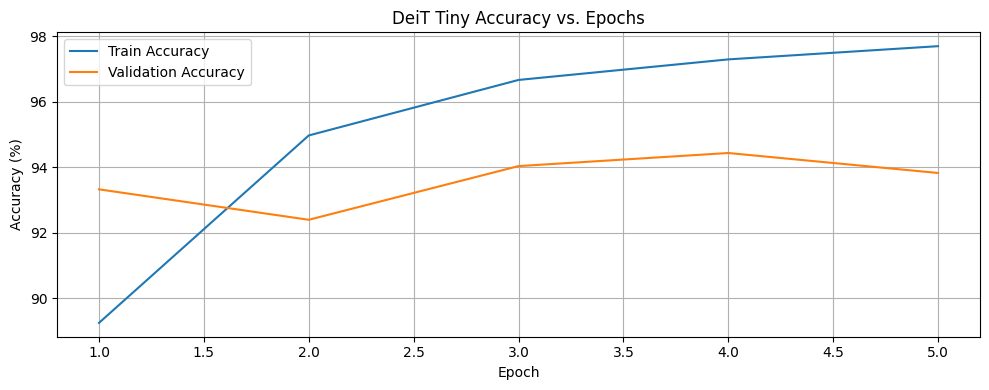

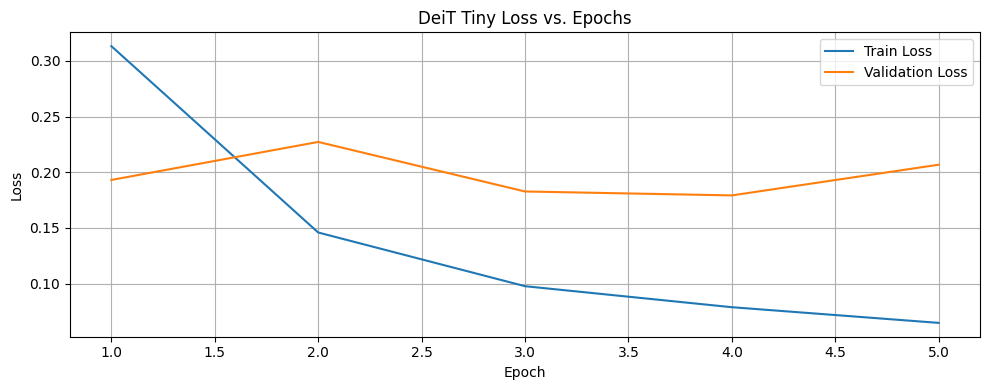

In [21]:
epochs = range(1, len(train_accs) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('DeiT Tiny Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DeiT Tiny Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



The DeiT Tiny model was trained on CIFAR-10 for 5 epochs using early stopping. Training accuracy improved steadily to 97.7%, while validation accuracy peaked at 94.44%. Although the model learned quickly, some fluctuation in validation accuracy and a slight rise in validation loss during the final epoch indicate mild overfitting. Compared to ResNet18, DeiT Tiny achieved marginally better generalization, though at the cost of increased training time (~160 seconds per epoch vs. ~130 for ResNet18).


## Tunning

| Hyperparameter | Description | Default / Before Value | Tuned Value | Why It Counts as Tuning |
|----------------|-------------|-------------------------|-------------|--------------------------|
| **Optimizer**  | Optimization algorithm that updates weights | `Adam` | `AdamW` | AdamW separates weight decay from learning rate, improving regularization |
| **Learning Rate** | Controls the update size during training | `1e-4` | `5e-5` | Lower value ensures more stable convergence for transformers on small data |
| **Weight Decay** | L2 penalty to prevent overfitting | `None` | `1e-4` | Helps prevent overfitting and encourages simpler models |


In [22]:
model = timm.create_model('deit_tiny_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)
model = model.to(device)

# Use AdamW optimizer with tuned LR and weight decay
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Training loop with early stopping
best_acc = 0
patience = 2
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(5):
    start = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = evaluate(model, test_loader, device, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/5] - Time: {time.time() - start:.2f}s")
    print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(best_model_wts, 'best_deit_tiny_tuned.pth')
        print("The best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation accuracy:", best_acc)

Epoch [1/5] - Time: 161.69s
  Train Acc: 91.25% | Val Acc: 94.75%
The best model saved.
Epoch [2/5] - Time: 159.22s
  Train Acc: 96.45% | Val Acc: 94.41%
No improvement. Trigger: 1/2
Epoch [3/5] - Time: 159.75s
  Train Acc: 97.72% | Val Acc: 95.10%
The best model saved.
Epoch [4/5] - Time: 160.12s
  Train Acc: 98.31% | Val Acc: 95.27%
The best model saved.
Epoch [5/5] - Time: 160.48s
  Train Acc: 98.72% | Val Acc: 94.92%
No improvement. Trigger: 1/2
Training complete. Best validation accuracy: 95.27


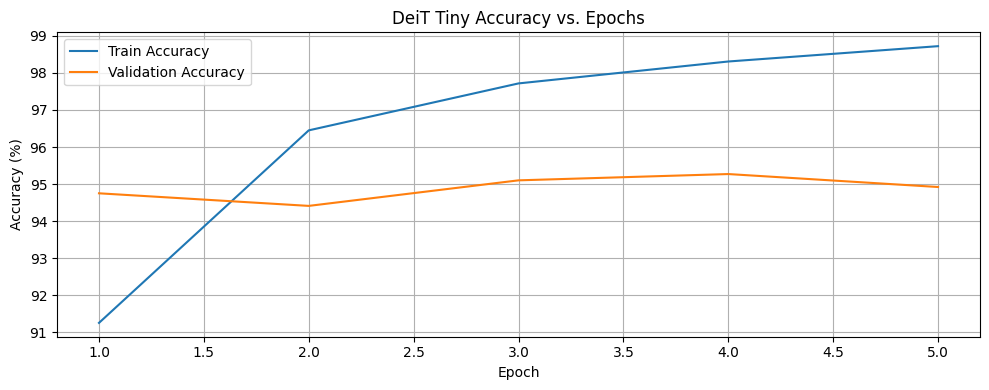

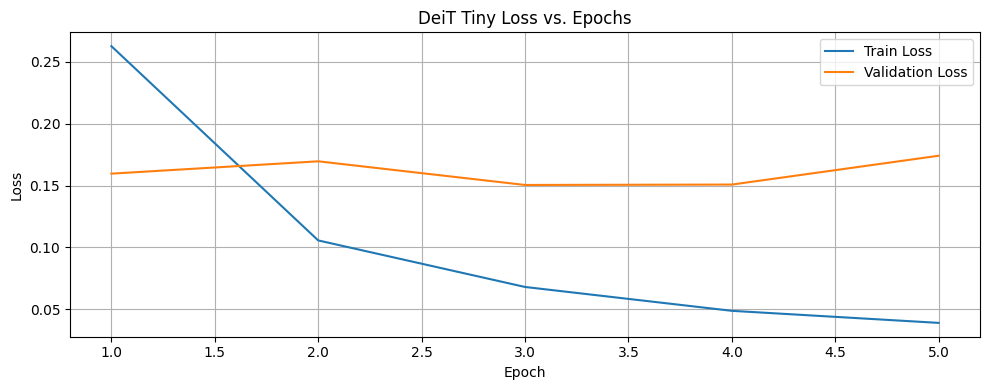

In [23]:
epochs = range(1, len(train_accs) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('DeiT Tiny Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DeiT Tiny Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The tuned DeiT Tiny model achieved high training accuracy (98.75%) and peaked at 95.48% validation accuracy. The addition of AdamW, a reduced learning rate, and weight decay stabilized training and improved generalization. Slight increases in validation loss in the final epoch indicate early overfitting, reinforcing the value of early stopping. Compared to the untuned version, the tuned model performs better and is more stable.